In [14]:
import numpy as np
import pandas as pd

import lightgbm
import matplotlib.pylab as plt
import os

from sklearn.model_selection import train_test_split
import sklearn

Inserting all features from test into one dataframe

In [15]:
folder_train = '../features_train_in_use'

features_train = pd.read_csv(os.path.join(folder_train, os.listdir(folder_train)[0]))
for i in range(1,len(os.listdir(folder_train))):
    f = os.path.join(folder_train,os.listdir(folder_train)[i])
    if os.path.isfile(f):
        features_train = pd.concat([features_train, pd.read_csv(f)], axis=1)
print(features_train)
        
        

       average_income_per_grunnkrets  numberOfBusstop categorical_chain_name  \
0                           561700.0             10.0              MCDONALDS   
1                           555720.0             30.0              MCDONALDS   
2                           495900.0             14.0            BURGER KING   
3                           521240.0             11.0            BURGER KING   
4                           585360.0             29.0            BURGER KING   
...                              ...              ...                    ...   
12854                       505640.0             27.0                    NaN   
12855                       396640.0             12.0       GULATING GRUPPEN   
12856                       549120.0             13.0       GULATING GRUPPEN   
12857                       498660.0             35.0                    NaN   
12858                       579780.0             10.0                    NaN   

      categorical_mall_name categorical

Repeat for test features

In [16]:
folder_test = '../features_test_in_use'

features_test = pd.read_csv(os.path.join(folder_test, os.listdir(folder_test)[0]))
for i in range(1,len(os.listdir(folder_test))):
    f = os.path.join(folder_test,os.listdir(folder_test)[i])
    if os.path.isfile(f):
        features_test = pd.concat([features_test, pd.read_csv(f)], axis=1)
print(features_test)
    

      average_income_per_grunnkrets  numberOfBusstop categorical_chain_name  \
0                          551600.0             21.0                    NaN   
1                          531240.0             11.0            BURGER KING   
2                          523300.0             11.0            BURGER KING   
3                          591380.0             22.0            BURGER KING   
4                          594020.0             21.0       VULKAN BURGERBAR   
...                             ...              ...                    ...   
8572                       560700.0              9.0       GULATING GRUPPEN   
8573                       593340.0             28.0                    NaN   
8574                       629100.0              6.0       GULATING GRUPPEN   
8575                       590100.0              8.0                    NaN   
8576                       529980.0              4.0                    NaN   

     categorical_mall_name categorical_plaace_2.ipy

Target train data:

In [17]:
target_train = pd.read_csv("../data/stores_train.csv")
target_train = target_train['revenue'].values

#log transform
target_train = np.log1p(target_train)

Light GBM model:

In [21]:
lgbm_model = lightgbm.LGBMRegressor(
    num_leaves=4,
    max_depth=5, 
    random_state=42, 
    silent=True, 
    metric='mse',
    n_jobs=4, 
    n_estimators=1000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.05
)

SyntaxError: positional argument follows keyword argument (3174499785.py, line 12)

In [19]:
target_train[""]

12859
[2.94433371 3.21197205 2.83901998 ... 3.6693143  1.53514531 1.20237152]
<class 'numpy.ndarray'>
12859


In [20]:
lgbm_model.fit(features_train, target_train)
lgbm_predictions = lgbm_model.predict(features_test)

#Undo log transform
lgbm_predictions = np.expm1(lgbm_predictions)

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: categorical_chain_name, categorical_mall_name, categorical_plaace_2.ipynb, sales_channel_name, categorical_street_2.ipynb

In [ ]:
print(lgbm_predictions)

[4.59272415 6.02481464 4.14623817 ... 3.27762128 3.19212497 1.8372243 ]


In [ ]:
stores_test = pd.read_csv("../data/stores_test.csv")
stores_test_id = stores_test['store_id'].values

In [ ]:
predictions = pd.DataFrame()

predictions['id'] = stores_test_id
predictions['predicted'] = lgbm_predictions
predictions.to_csv("../predictions/lightGBM21.csv", index=False)
print(predictions)


                              id  predicted
0     914206820-914239427-717245   4.592724
1     916789157-916823770-824309   6.024815
2       913341082-977479363-2948   4.146238
3      889682582-889697172-28720   4.638856
4     997991699-998006945-417222   3.854689
...                          ...        ...
8572  917323003-917383529-844309   2.381667
8573  917353379-917411824-845904   3.327897
8574  917072302-917089248-833647   3.277621
8575  916960557-916993161-829908   3.192125
8576   987280891-972040746-45320   1.837224

[8577 rows x 2 columns]


In [ ]:
def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error 
    
    Args:
        y_true (np.array): n-dimensional vector of ground-truth values 
        y_pred (np.array): n-dimensional vecotr of predicted values 
    
    Returns:
        A scalar float with the rmsle value 
    
    Note: You can alternatively use sklearn and just do: 
        `sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5`
    """
    assert (y_true >= 0).all(), 'Received negative y_true values'
    assert (y_pred >= 0).all(), 'Received negative y_pred values'
    assert y_true.shape == y_pred.shape, 'y_true and y_pred have different shapes'
    y_true_log1p = np.log1p(y_true)  # log(1 + y_true)
    y_pred_log1p = np.log1p(y_pred)  # log(1 + y_pred)
    return np.sqrt(np.mean(np.square(y_pred_log1p - y_true_log1p)))


X_train, X_test, y_train, y_test = train_test_split(features_train, target_train, test_size=0.2, random_state=42)

lgbm_model2 = lightgbm.LGBMRegressor(
    num_leaves=4,
    max_depth=5, 
    random_state=42, 
    silent=True, 
    metric='mse',
    n_jobs=4, 
    n_estimators=1000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.05
)

lgbm_model2.fit(X_train, y_train)
y_pred = lgbm_model2.predict(X_test)
# Calculate rmsle for a few example predictions 
y_true = y_test
n = len(features_train)
print('A couple of RMSLE scores computed over the train set')
print(f'Perfect prediction: {rmsle(y_true, y_true):.4f}')
print(f'Score: {rmsle(y_true, y_pred):.4f}')

print("Score: ",sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5)

c:\Users\47457\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


A couple of RMSLE scores computed over the train set
Perfect prediction: 0.0000
Score: 0.3387
Score:  0.3386790376249269


In [ ]:
import shap

c:\Users\47457\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


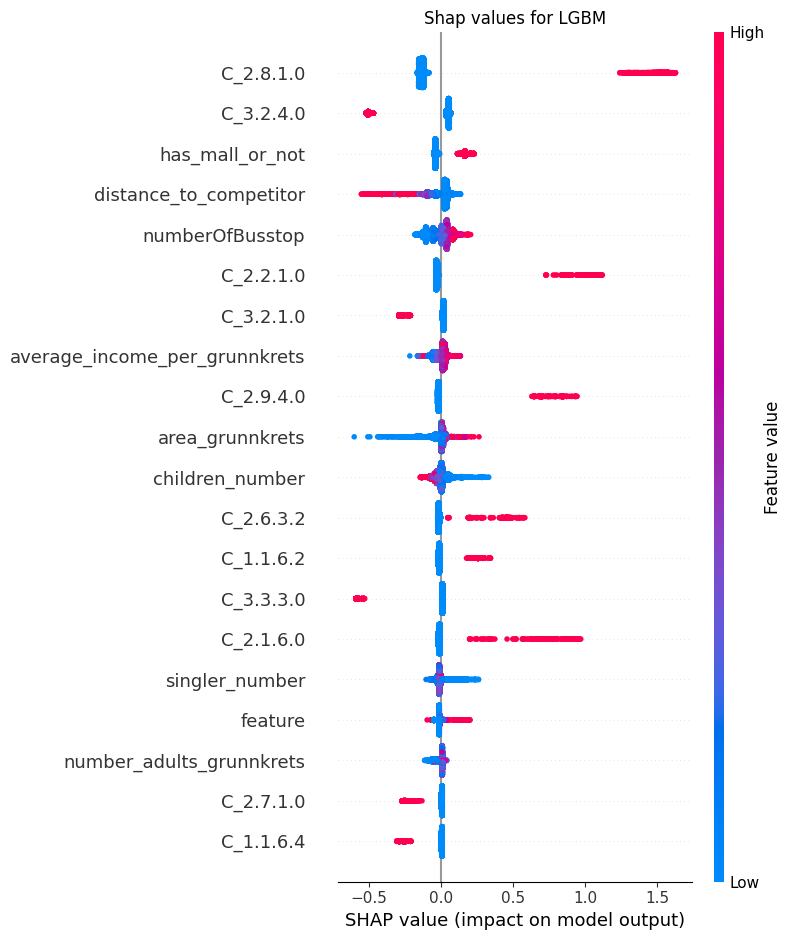

In [ ]:
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(features_train)

plt.title('Shap values for LGBM')
shap.summary_plot(shap_values, features_train)